## Import libraries

In [2]:
import motor.motor_asyncio
from pprint import pprint
import asyncio
from config import mongo_config
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
import folium
import numpy as np
from folium.plugins import HeatMap

import warnings
warnings.filterwarnings('ignore')

## Read data from MongoDB

In [3]:
client = motor.motor_asyncio.AsyncIOMotorClient()
shards = ",".join(mongo_config["shards"])
client = motor.motor_asyncio.AsyncIOMotorClient(f'mongodb://{mongo_config["username"]}:{mongo_config["pwd"]}@{shards}?authSource=admin&readPreference=primary&ssl=true&ssl_cert_reqs=CERT_NONE')
db = client["house-price-db"]
collection = db["house-price"]

In [4]:
async def do_find(collection, n: int = 0):

    if n == 0:
        cursor = collection.find()
    else:
        cursor = collection.find().limit(n)
    
    all_docs = []
    async for document in cursor:
        all_docs.append(document)
    return all_docs

In [5]:
docs = await do_find(collection, 0)
print("\n[INFO] : Data successfully pulled from Mongo DB!\n")


[INFO] : Data successfully pulled from Mongo DB!



In [6]:
df = pd.DataFrame.from_records(docs)
print(df.shape)

(21613, 22)


## Defining a metric to evaluate against

Since the problem is of regression type with multiple features involved, we select Adjusted R^2 as our evaluation metric.

This is because:

1. R^2 based metrics are particular to regression problems.
2. Adjusted R^2 takes into account number of features and standardizes the metric.


R^2 basically quantifies the amount of variance explained by a model as a ratio of the total data variance. This tells us how effective a model is at explaining the variance inside a dataset. Adjusted R^2 adjusts this metric for number of rows and features in the dataset.

We define Adjusted R^2 as follows:

$\bar{R^{2}}=R^{2}-\frac{k-1}{n-k}(1-R^{2})$

An Adj.R2 closer to 1 means the model is fairly good on the dataset.

Apart from this, we also measure the Root Mean Square Errors (RMSEs) of train and test data. This metric gives us an idea of how underfit/overfit the model might be and what degree of error can we expect from the model under normal circumstances.

We define RMSE as follows:

$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{(y_i - \hat{y_i})^2}}$

*where $y_i$ is the ground truth and $\hat{y_i}$ is the prediction for that datapoint.*


In [7]:
def adjustedR2(r2: float, n: int,k: int):
    """
    Returns the Adjusted R^2 metric given R^2 value and dataset size

    [Args]:
    r2:float : The R-squared value of the inferences from a model.
    n:int    : The number of rows in inference dataset
    k:int    : The number of features in inference dataset

    [Returns]:
    The Adjusted R^2 metric as float
    """
    return r2-(k-1)/(n-k)*(1-r2)

## Exploratory Data Analysis

In [8]:
df.head()

,_id,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,60a3d6e8bb6ca0237c0939a8,7129300520,20141013T000000,221900,3,1,1180,5650,1,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,60a3d6e8bb6ca0237c0939a9,6414100192,20141209T000000,538000,3,2.25,2570,7242,2,0,...,7,2170,400,1951,1991,98125,47.721,-122.319,1690,7639
2,60a3d6e8bb6ca0237c0939aa,5631500400,20150225T000000,180000,2,1,770,10000,1,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,60a3d6e8bb6ca0237c0939ab,2487200875,20141209T000000,604000,4,3,1960,5000,1,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,60a3d6e8bb6ca0237c0939ac,1954400510,20150218T000000,510000,3,2,1680,8080,1,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Fix datatypes

In [9]:
data_types_dict = {'id': str,
                   '_id': str,
                   'price': float,
                   'bedrooms': int,
                   'bathrooms': float,
                   'sqft_living': float,
                   'sqft_lot': float,
                   'floors': float,
                   'waterfront': int,
                   'view': int,
                   'condition': int,
                   'grade': int,
                   'sqft_above': float,
                   'sqft_basement': float,
                   'yr_built': int,
                   'yr_renovated': int,
                   'zipcode': int,
                   'lat': float,
                   'long': float,
                   'sqft_living15': float,
                   'sqft_lot15': float
                  }

df = df.astype(data_types_dict)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   _id            21613 non-null  object 
 1   id             21613 non-null  object 
 2   date           21613 non-null  object 
 3   price          21613 non-null  float64
 4   bedrooms       21613 non-null  int32  
 5   bathrooms      21613 non-null  float64
 6   sqft_living    21613 non-null  float64
 7   sqft_lot       21613 non-null  float64
 8   floors         21613 non-null  float64
 9   waterfront     21613 non-null  int32  
 10  view           21613 non-null  int32  
 11  condition      21613 non-null  int32  
 12  grade          21613 non-null  int32  
 13  sqft_above     21613 non-null  float64
 14  sqft_basement  21613 non-null  float64
 15  yr_built       21613 non-null  int32  
 16  yr_renovated   21613 non-null  int32  
 17  zipcode        21613 non-null  int32  
 18  lat   

### Data summary

In [11]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### Univariate Analysis

We use histograms to analyse the distribution of each variable individually.

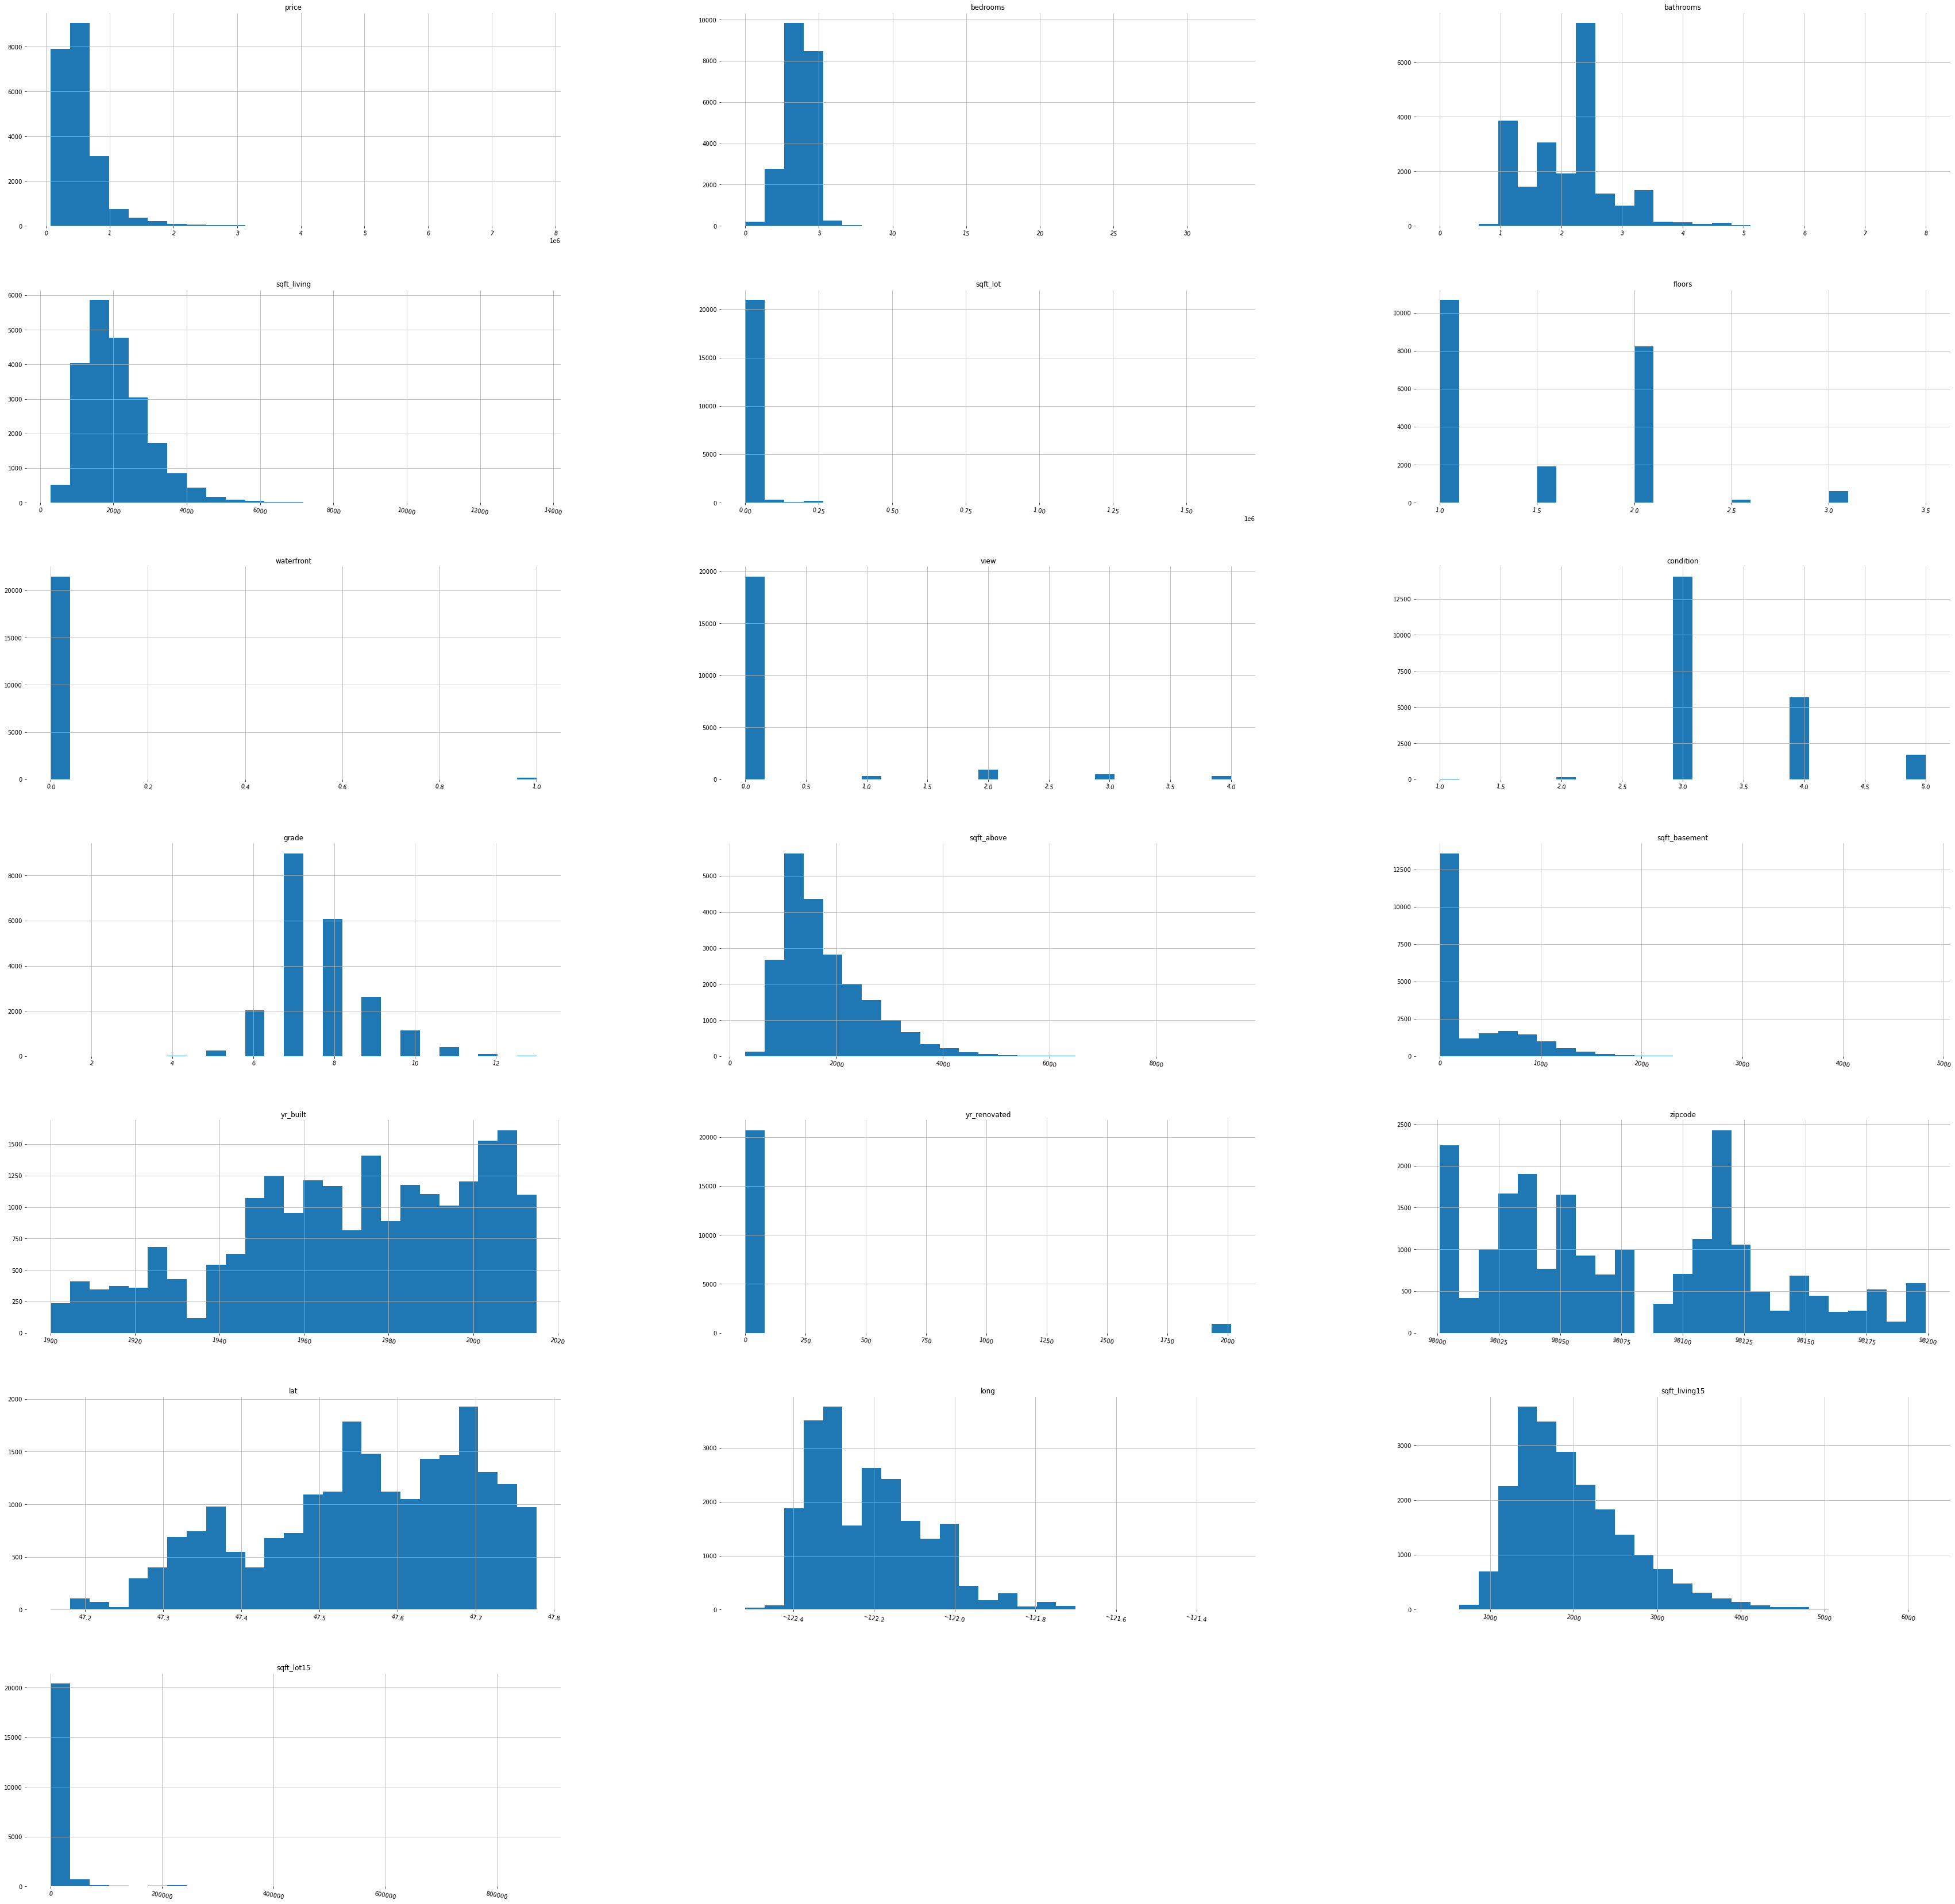

In [12]:
df1=df[['price', 'bedrooms', 'bathrooms', 'sqft_living',
    'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
    'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
    'lat', 'long', 'sqft_living15', 'sqft_lot15']]

params = {'axes.titlesize':'32',
          'xtick.labelsize':'24',
          'ytick.labelsize':'24'}

h = df1.hist(bins=25,figsize=(60,60),xrot=-10, layout=(7,3))
matplotlib.rcParams.update(params)
sns.despine(left=True, bottom=True)
[x.yaxis.tick_left() for x in h.ravel()];

### Bivariate Analysis

**Analysing certain input variables wrt price ie our target variable.**

In [13]:
sns.set(style="whitegrid", font_scale=1)

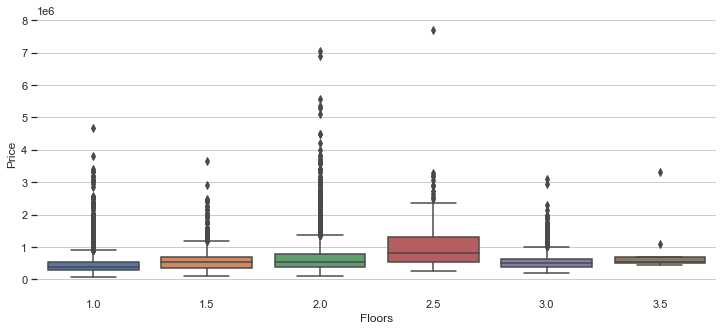

In [14]:
f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=df['floors'],y=df['price'], ax=axe)
axe.yaxis.tick_left()
axe.set(xlabel='Floors', ylabel='Price');

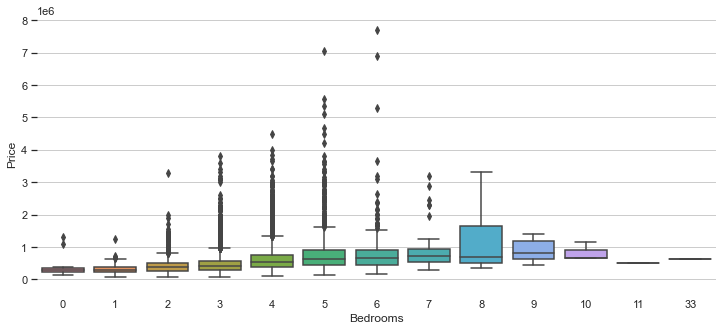

In [15]:
f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=df['bedrooms'],y=df['price'], ax=axe)
axe.yaxis.tick_left()
axe.set(xlabel='Bedrooms', ylabel='Price');

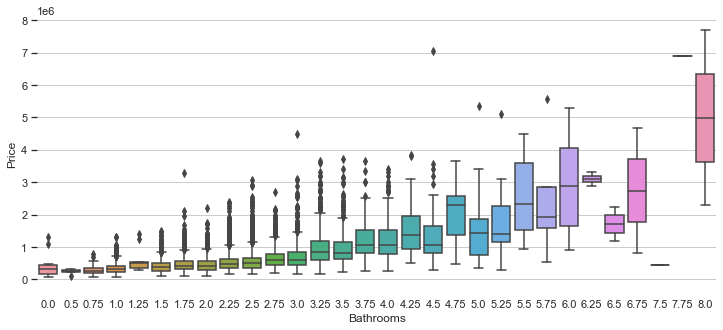

In [16]:
f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=df['bathrooms'],y=df['price'], ax=axe)
axe.yaxis.tick_left()
axe.set(xlabel='Bathrooms', ylabel='Price');

On drawing the price vs features plots, it seems that there is not a perfect linear relationship between the price and these features.

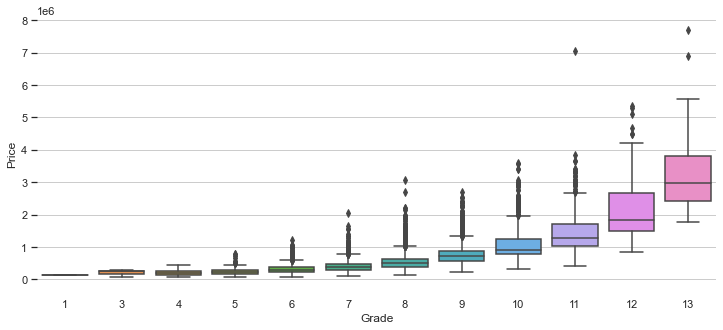

In [17]:
f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=df['grade'],y=df['price'], ax=axe)
axe.yaxis.tick_left()
axe.set(xlabel='Grade', ylabel='Price');

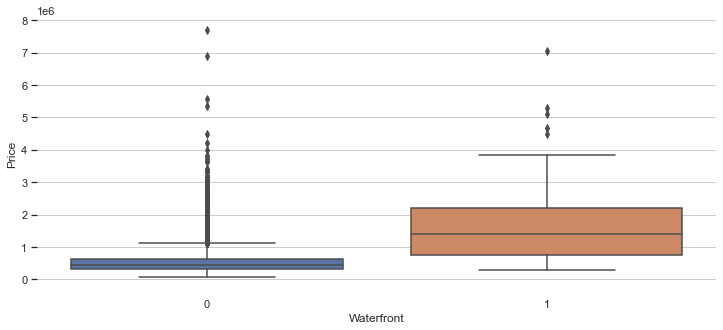

In [18]:
f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=df['waterfront'],y=df['price'], ax=axe)
axe.yaxis.tick_left()
axe.set(xlabel='Waterfront', ylabel='Price');

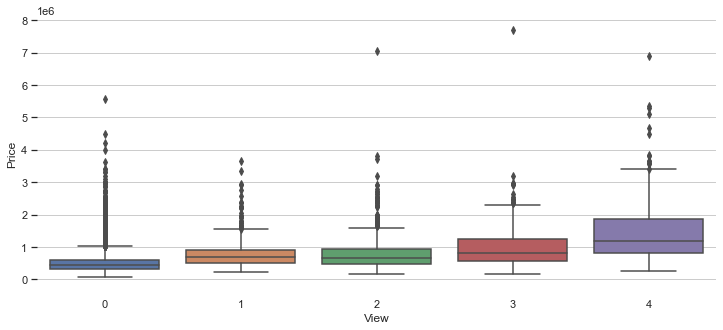

In [19]:
f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=df['view'],y=df['price'], ax=axe)
axe.yaxis.tick_left()
axe.set(xlabel='View', ylabel='Price');

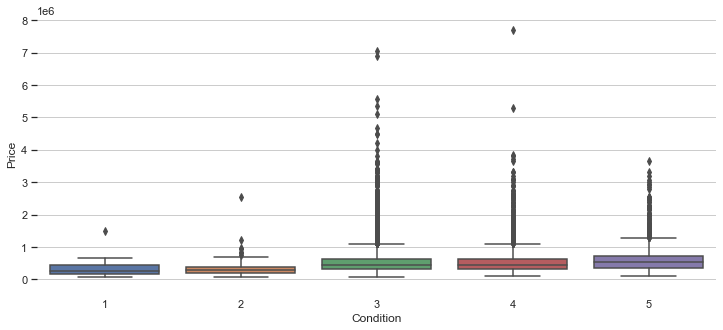

In [20]:
f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=df['condition'],y=df['price'], ax=axe)
axe.yaxis.tick_left()
axe.set(xlabel='Condition', ylabel='Price');

When we look at the boxplots, grade and waterfront effect price visibly. On the other hand, view seem to have a lesser effect on price. And condition barely shows any impact.

**Now, looking at the relationship between different features.**

[(0.0, 12.0)]

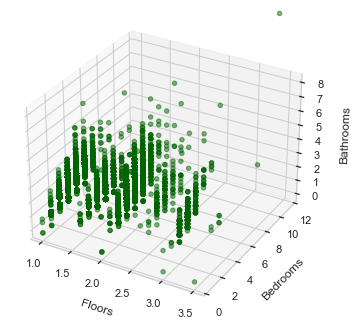

In [21]:
fig=plt.figure(figsize=(19,12.5))
ax=fig.add_subplot(2,2,1, projection="3d")
ax.scatter(df['floors'],df['bedrooms'],df['bathrooms'],c="darkgreen",alpha=.5)
ax.set(xlabel='\nFloors',ylabel='\nBedrooms',zlabel='\nBathrooms')
ax.set(ylim=[0,12])

[(0.0, 12.0)]

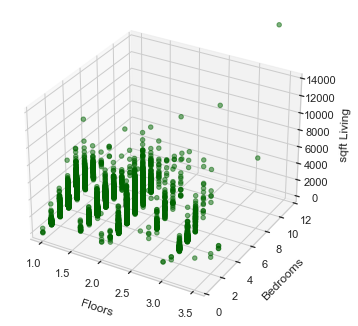

In [22]:
fig=plt.figure(figsize=(19,12.5))
ax=fig.add_subplot(2,2,2, projection="3d")
ax.scatter(df['floors'],df['bedrooms'],df['sqft_living'],c="darkgreen",alpha=.5)
ax.set(xlabel='\nFloors',ylabel='\nBedrooms',zlabel='\nsqft Living')
ax.set(ylim=[0,12])


[(0.0, 250000.0)]

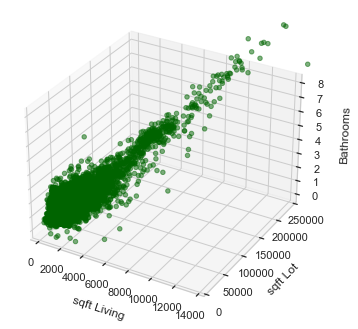

In [23]:
fig=plt.figure(figsize=(19,12.5))
ax=fig.add_subplot(2,2,3, projection="3d")
ax.scatter(df['sqft_living'],df['sqft_lot'],df['bathrooms'],c="darkgreen",alpha=.5)
ax.set(xlabel='\n sqft Living',ylabel='\nsqft Lot',zlabel='\nBathrooms')
ax.set(ylim=[0,250000])

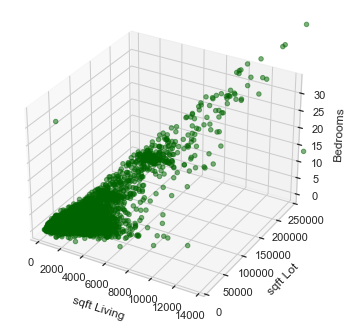

In [24]:
fig=plt.figure(figsize=(19,12.5))
ax=fig.add_subplot(2,2,4, projection="3d")
ax.scatter(df['sqft_living'],df['sqft_lot'],df['bedrooms'],c="darkgreen",alpha=.5)
ax.set(xlabel='\n sqft Living',ylabel='\nsqft Lot',zlabel='Bedrooms')
ax.set(ylim=[0,250000]);

The charts show that when the sqrt_living increases, sqrt_lot and bedrooms or bathrooms increases. However, the floors, bedrooms and bathrooms or sqrt_living does not have a similar relationship.

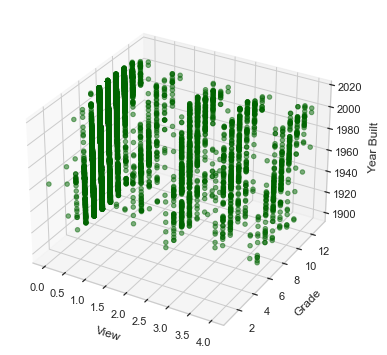

In [25]:
fig=plt.figure(figsize=(9.5,6.25))
ax=fig.add_subplot(1,1,1, projection="3d")
ax.scatter(df['view'],df['grade'],df['yr_built'],c="darkgreen",alpha=.5)
ax.set(xlabel='\nView',ylabel='\nGrade',zlabel='\nYear Built');

We can say that the newer houses have better grades but we can not say much about the change in the view. 

### Heatmap for locations

By using the lat and long columns, we display a heat map showing the distribution of houses. A marker points at the house with the highest price.

In [26]:
maxpr=df.loc[df['price'].idxmax()]

def generateBaseMap(default_location=[47.5112, -122.257], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

df_copy = df.copy()

df_copy['count'] = 1
basemap = generateBaseMap()

folium.TileLayer('cartodbpositron').add_to(basemap)
s=folium.FeatureGroup(name='icon').add_to(basemap)

folium.Marker([maxpr['lat'], maxpr['long']],popup='Highest Price: $'+str(format(maxpr['price'],'.0f')),
              icon=folium.Icon(color='green')).add_to(s)

HeatMap(data=df_copy[['lat','long','count']].groupby(['lat','long']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)

basemap

### Correlation Matrix

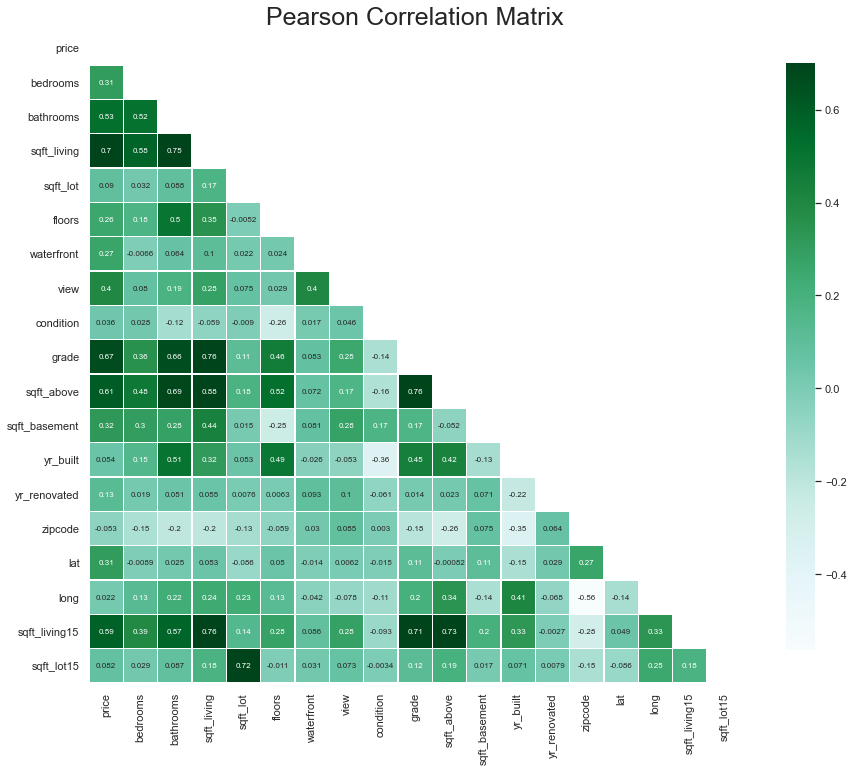

In [27]:
mask = np.zeros_like(df1.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df1.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

## Data Pre-processing

### Remove columns

In [28]:
df_dm=df[['price', 'bedrooms', 'bathrooms', 'sqft_living',
    'floors', 'waterfront', 'view', 'grade',
    'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
    'date', 'lat', 'sqft_living15']]


In [29]:
df_dm.describe()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,sqft_living15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.494309,0.007542,0.234303,7.656873,1788.390691,291.509045,1971.005136,84.402258,47.560053,1986.552492
std,3.671272e+05,0.930062,0.770163,918.440897,0.539989,0.086517,0.766318,1.175459,828.090978,442.575043,29.373411,401.679240,0.138564,685.391304
min,7.500000e+04,0.000000,0.000000,290.000000,1.000000,0.000000,0.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,399.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,1.000000,0.000000,0.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.471000,1490.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,1.500000,0.000000,0.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.571800,1840.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,2.000000,0.000000,0.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,47.678000,2360.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,3.500000,1.000000,4.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,6210.000000


### Binning

Data binning is a preprocessing technique used to reduce the effects of minor observation errors. It has been applied to yr_built and yr_renovated. We added the ages and renovation ages of the houses when they were sold. Also, we partitioned these columns to intervals and plotted histograms. 

In [30]:
df_dm['sales_yr']=df_dm['date'].astype(str).str[:4]

In [31]:
df_dm['age']=df_dm['sales_yr'].astype(int)-df_dm['yr_built']

bins = [-2,0,5,10,25,50,75,100,100000]
labels = ['<1','1-5','6-10','11-25','26-50','51-75','76-100','>100']
df_dm['age_binned'] = pd.cut(df_dm['age'], bins=bins, labels=labels)

In [32]:
df_dm['age_rnv']=0
df_dm['age_rnv']=df_dm['sales_yr'][df_dm['yr_renovated']!=0].astype(int)-df_dm['yr_renovated'][df_dm['yr_renovated']!=0]
df_dm['age_rnv'][df_dm['age_rnv'].isnull()]=0

bins = [-2,0,5,10,25,50,75,100000]
labels = ['<1','1-5','6-10','11-25','26-50','51-75','>75']
df_dm['age_rnv_binned'] = pd.cut(df_dm['age_rnv'], bins=bins, labels=labels)

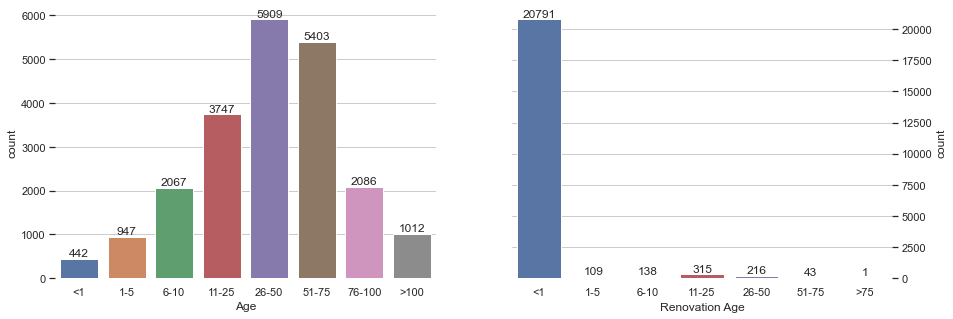

In [33]:
f, axes = plt.subplots(1, 2,figsize=(15,5))
p1=sns.countplot(df_dm['age_binned'],ax=axes[0])
for p in p1.patches:
    height = p.get_height()
    p1.text(p.get_x()+p.get_width()/2,height + 50,height,ha="center")   
p2=sns.countplot(df_dm['age_rnv_binned'],ax=axes[1])
sns.despine(left=True, bottom=True)
for p in p2.patches:
    height = p.get_height()
    p2.text(p.get_x()+p.get_width()/2,height + 200,height,ha="center")
    
axes[0].set(xlabel='Age')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='Renovation Age');


df_dm = pd.get_dummies(df_dm, columns=['age_binned','age_rnv_binned'])

In [34]:
df_dm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 21613 non-null  float64
 1   bedrooms              21613 non-null  int32  
 2   bathrooms             21613 non-null  float64
 3   sqft_living           21613 non-null  float64
 4   floors                21613 non-null  float64
 5   waterfront            21613 non-null  int32  
 6   view                  21613 non-null  int32  
 7   grade                 21613 non-null  int32  
 8   sqft_above            21613 non-null  float64
 9   sqft_basement         21613 non-null  float64
 10  yr_built              21613 non-null  int32  
 11  yr_renovated          21613 non-null  int32  
 12  date                  21613 non-null  object 
 13  lat                   21613 non-null  float64
 14  sqft_living15         21613 non-null  float64
 15  sales_yr           

# Multiple Regression

We intended to add more functionality to the model in order to enhance it. Multiple regression is used where there are more than one feature of a linear regression. Then it's time to create some complex models.

 ## Multiple Regression - 1

We identified features at first glance by reviewing previous parts and using them in the first multiple linear regression. However, if we want to make manual measurements, we must use the definition below for our predictions this time. 

$$h_{\theta}(X)=\theta_{0}+\theta_{1}x_{1}+\theta_{2}x_{2}+...+\theta_{n}x_{n}$$

In [45]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from mpl_toolkits.mplot3d import Axes3D

evaluation = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           '5-Fold Cross Validation':[]})

In [36]:
train_data_dm,test_data_dm = train_test_split(df_dm,train_size = 0.8,random_state=3)


features = ['bedrooms','bathrooms','sqft_living','floors','waterfront','view',
             'grade','age_binned_<1', 'age_binned_1-5', 'age_binned_6-10','age_binned_11-25', 
             'age_binned_26-50', 'age_binned_51-75','age_binned_76-100', 'age_binned_>100']
complex_model_2 = linear_model.LinearRegression()
complex_model_2.fit(train_data_dm[features],train_data_dm['price'])

print('Intercept: {}'.format(complex_model_2.intercept_))
print('Coefficients: {}'.format(complex_model_2.coef_))

pred = complex_model_2.predict(test_data_dm[features])
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred)),'.3f'))
rtrcm = float(format(complex_model_2.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm = float(format(adjustedR2(complex_model_2.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm = float(format(complex_model_2.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm = float(format(adjustedR2(complex_model_2.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv = float(format(cross_val_score(complex_model_2,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression-1','selected features',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

Intercept: -769690.7061408515
Coefficients: [-3.61797529e+04  4.85966009e+04  1.70218847e+02  9.23687754e+03
  5.58161334e+05  4.63376699e+04  1.24368458e+05 -8.63456378e+04
 -1.02109887e+05 -1.02916415e+05 -1.33912067e+05 -5.13670538e+04
  8.01112830e+04  1.79165767e+05  2.17374011e+05]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Multiple Regression-1,selected features,209918.749,0.651,0.651,0.657,0.656,0.647


 ## Multiple Regression - 2

To make it easier to see variations, we built a model with all features without any preprocessing. Metrics for evaluation have changed noticeably once more.

In [38]:
train_data,test_data = train_test_split(df,train_size = 0.8,random_state=3)

features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view',
            'condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated',
            'zipcode','lat','long','sqft_living15','sqft_lot15']
complex_model_3 = linear_model.LinearRegression()
complex_model_3.fit(train_data[features],train_data['price'])

print('Intercept: {}'.format(complex_model_3.intercept_))
print('Coefficients: {}'.format(complex_model_3.coef_))

pred = complex_model_3.predict(test_data[features])
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'],pred)),'.3f'))
rtrcm = float(format(complex_model_3.score(train_data[features],train_data['price']),'.3f'))
artrcm = float(format(adjustedR2(complex_model_3.score(train_data[features],train_data['price']),train_data.shape[0],len(features)),'.3f'))
rtecm = float(format(complex_model_3.score(test_data[features],test_data['price']),'.3f'))
artecm = float(format(adjustedR2(complex_model_3.score(test_data[features],test_data['price']),test_data.shape[0],len(features)),'.3f'))
cv = float(format(cross_val_score(complex_model_3,df[features],df['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression-2','all features, no preprocessing',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

Intercept: 7580919.940357786
Coefficients: [-3.51323305e+04  4.25821114e+04  1.10705020e+02  1.13581822e-01
  6.82992716e+03  5.61794985e+05  5.28174040e+04  2.48918356e+04
  9.57708783e+04  7.01998424e+01  4.05051776e+01 -2.70948034e+03
  2.26715091e+01 -5.80427853e+02  5.98629230e+05 -2.08875497e+05
  2.32857416e+01 -3.75353459e-01]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
1,Multiple Regression-2,"all features, no preprocessing",193693.989,0.698,0.697,0.708,0.707,0.695
0,Multiple Regression-1,selected features,209918.749,0.651,0.651,0.657,0.656,0.647


 ## Multiple Regression - 3

This time we used the data obtained after preprocessing step.

In [41]:
features = ['bedrooms','bathrooms','sqft_living','floors','waterfront',
            'view','grade','sqft_above','sqft_basement','age_binned_<1', 
            'age_binned_1-5', 'age_binned_6-10','age_binned_11-25', 'age_binned_26-50',
            'age_binned_51-75','age_binned_76-100', 'age_binned_>100','age_rnv_binned_<1',
            'age_rnv_binned_1-5', 'age_rnv_binned_6-10', 'age_rnv_binned_11-25',
            'age_rnv_binned_26-50', 'age_rnv_binned_51-75', 'age_rnv_binned_>75',
            'lat','sqft_living15']
complex_model_4 = linear_model.LinearRegression()
complex_model_4.fit(train_data_dm[features],train_data_dm['price'])

print('Intercept: {}'.format(complex_model_4.intercept_))
print('Coefficients: {}'.format(complex_model_4.coef_))

pred = complex_model_4.predict(test_data_dm[features])
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred)),'.3f'))
rtrcm = float(format(complex_model_4.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm = float(format(adjustedR2(complex_model_4.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm = float(format(complex_model_4.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm = float(format(adjustedR2(complex_model_4.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv = float(format(cross_val_score(complex_model_4,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression-3','all features',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

Intercept: -26878560.13751232
Coefficients: [-3.08488503e+04  4.33469640e+04  1.08927801e+02 -1.24630623e+04
  5.75799376e+05  5.20321994e+04  1.00280311e+05  6.45902513e+01
  4.43375498e+01 -5.94200716e+04 -7.01120328e+04 -8.72302533e+04
 -1.03555710e+05 -4.71454257e+04  4.75406559e+04  1.39472838e+05
  1.80449999e+05 -1.07848643e+04  8.05137184e+04  7.07435688e+04
  3.00043250e+04 -1.17323610e+04 -1.01001330e+05 -5.77430572e+04
  5.52677825e+05  2.25001182e+01]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
1,Multiple Regression-2,"all features, no preprocessing",193693.989,0.698,0.697,0.708,0.707,0.695
2,Multiple Regression-3,all features,196203.103,0.691,0.691,0.700,0.698,0.687
0,Multiple Regression-1,selected features,209918.749,0.651,0.651,0.657,0.656,0.647


 ## Regularization

**Regularization** is intended to resolve the issue of overfitting and underfitting. **Overfitting** refers to high variance and is typically generated by a complex function that generates a large number of unwanted curves and angles unrelated to the results. This feature suits training data well but can provide bad test set outcomes. **Underfitting**, on the other hand, denotes a low variance and a very simplistic construct. This could also lead to disappointing performances. **Possible solutions** include manually changing features or using model selection algorithms, which adds to the workload. When we use regularization, all of the characteristics are preserved, and the model changes $\theta_{j}$.

This is particularly effective when we have a large number of marginally useful functions. There are two forms of regularization that are commonly used (Ridge and Lasso Regressions), and I used both of them in this section.

**When to use ridge regression vs lasso regression:** 
* Use *ridge* for several small/medium sized impacts.
* Use *lasso* if there are just a few variables with a medium/large effect.

 ## Ridge Regression 

Ridge regression is called **L2 regularization** and by adding a penalty, we obtain the below equation

$$RSS_{RIDGE} = \sum_{i=1}^{m}(h_{\theta}(x_{i})-y_{i})^{2} + \alpha \sum_{j=1}^{n}\theta^{2}_{j}$$

By changing the $\alpha$ value, we can control the amount of the regularization. When we increase $\alpha$, regularization increases and the opposite is valid too. As a result of this, I selected different $\alpha$ values and used a linear regression without regularization in order to observe the differences easily.

In [43]:
features = ['bedrooms','bathrooms','sqft_living','floors','waterfront',
            'view','grade','sqft_above','sqft_basement','age_binned_<1', 
            'age_binned_1-5', 'age_binned_6-10','age_binned_11-25', 'age_binned_26-50',
            'age_binned_51-75','age_binned_76-100', 'age_binned_>100','age_rnv_binned_<1',
            'age_rnv_binned_1-5', 'age_rnv_binned_6-10', 'age_rnv_binned_11-25',
            'age_rnv_binned_26-50', 'age_rnv_binned_51-75', 'age_rnv_binned_>75',
            'lat','sqft_living15']

complex_model_R = linear_model.Ridge(alpha=1)
complex_model_R.fit(train_data_dm[features],train_data_dm['price'])

pred1 = complex_model_R.predict(test_data_dm[features])
rmsecm1 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred1)),'.3f'))
rtrcm1 = float(format(complex_model_R.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm1 = float(format(adjustedR2(complex_model_R.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm1 = float(format(complex_model_R.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm1 = float(format(adjustedR2(complex_model_R.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv1 = float(format(cross_val_score(complex_model_R,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

complex_model_R = linear_model.Ridge(alpha=100)
complex_model_R.fit(train_data_dm[features],train_data_dm['price'])

pred2 = complex_model_R.predict(test_data_dm[features])
rmsecm2 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred2)),'.3f'))
rtrcm2 = float(format(complex_model_R.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm2 = float(format(adjustedR2(complex_model_R.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm2 = float(format(complex_model_R.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm2 = float(format(adjustedR2(complex_model_R.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv2 = float(format(cross_val_score(complex_model_R,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

complex_model_R = linear_model.Ridge(alpha=1000)
complex_model_R.fit(train_data_dm[features],train_data_dm['price'])

pred3 = complex_model_R.predict(test_data_dm[features])
rmsecm3 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred3)),'.3f'))
rtrcm3 = float(format(complex_model_R.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm3 = float(format(adjustedR2(complex_model_R.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm3 = float(format(complex_model_R.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm3 = float(format(adjustedR2(complex_model_R.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv3 = float(format(cross_val_score(complex_model_R,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Ridge Regression','alpha=1, all features',rmsecm1,rtrcm1,artrcm1,rtecm1,artecm1,cv1]
evaluation.loc[r+1] = ['Ridge Regression','alpha=100, all features',rmsecm2,rtrcm2,artrcm2,rtecm2,artecm2,cv2]
evaluation.loc[r+2] = ['Ridge Regression','alpha=1000, all features',rmsecm3,rtrcm3,artrcm3,rtecm3,artecm3,cv3]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
1,Multiple Regression-2,"all features, no preprocessing",193693.989,0.698,0.697,0.708,0.707,0.695
2,Multiple Regression-3,all features,196203.103,0.691,0.691,0.700,0.698,0.687
3,Ridge Regression,"alpha=1, all features",196222.263,0.691,0.691,0.700,0.698,0.687
4,Ridge Regression,"alpha=100, all features",199063.512,0.685,0.684,0.691,0.689,0.681
0,Multiple Regression-1,selected features,209918.749,0.651,0.651,0.657,0.656,0.647
5,Ridge Regression,"alpha=1000, all features",211530.361,0.645,0.645,0.651,0.649,0.642


 ## Lasso Regression

Lasso regression is called **L1 regularization** and it is defined as

$$RSS_{LASSO} = \sum_{i=1}^{m}(h_{\theta}(x_{i})-y_{i})^{2} + \alpha \sum_{j=1}^{n}|\theta_{j}|$$

The main difference between ridge and lasso is the penalty but $\alpha$ works the same way.   

In [44]:
features = ['bedrooms','bathrooms','sqft_living','floors','waterfront',
            'view','grade','sqft_above','sqft_basement','age_binned_<1', 
            'age_binned_1-5', 'age_binned_6-10','age_binned_11-25', 'age_binned_26-50',
            'age_binned_51-75','age_binned_76-100', 'age_binned_>100','age_rnv_binned_<1',
            'age_rnv_binned_1-5', 'age_rnv_binned_6-10', 'age_rnv_binned_11-25',
            'age_rnv_binned_26-50', 'age_rnv_binned_51-75', 'age_rnv_binned_>75',
            'lat','sqft_living15']

complex_model_L = linear_model.Lasso(alpha=1)
complex_model_L.fit(train_data_dm[features],train_data_dm['price'])

pred1 = complex_model_L.predict(test_data_dm[features])
rmsecm1 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred1)),'.3f'))
rtrcm1 = float(format(complex_model_L.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm1 = float(format(adjustedR2(complex_model_L.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm1 = float(format(complex_model_L.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm1 = float(format(adjustedR2(complex_model_L.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv1 = float(format(cross_val_score(complex_model_L,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

complex_model_L = linear_model.Lasso(alpha=100)
complex_model_L.fit(train_data_dm[features],train_data_dm['price'])

pred2 = complex_model_L.predict(test_data_dm[features])
rmsecm2 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred2)),'.3f'))
rtrcm2 = float(format(complex_model_L.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm2 = float(format(adjustedR2(complex_model_L.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm2 = float(format(complex_model_L.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm2 = float(format(adjustedR2(complex_model_L.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv2 = float(format(cross_val_score(complex_model_L,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

complex_model_L = linear_model.Lasso(alpha=1000)
complex_model_L.fit(train_data_dm[features],train_data_dm['price'])

pred3 = complex_model_L.predict(test_data_dm[features])
rmsecm3 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred3)),'.3f'))
rtrcm3 = float(format(complex_model_L.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm3 = float(format(adjustedR2(complex_model_L.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm3 = float(format(complex_model_L.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm3 = float(format(adjustedR2(complex_model_L.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv3 = float(format(cross_val_score(complex_model_L,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Lasso Regression','alpha=1, all features',rmsecm1,rtrcm1,artrcm1,rtecm1,artecm1,cv1]
evaluation.loc[r+1] = ['Lasso Regression','alpha=100, all features',rmsecm2,rtrcm2,artrcm2,rtecm2,artecm2,cv2]
evaluation.loc[r+2] = ['Lasso Regression','alpha=1000, all features',rmsecm3,rtrcm3,artrcm3,rtecm3,artecm3,cv3]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
1,Multiple Regression-2,"all features, no preprocessing",193693.989,0.698,0.697,0.708,0.707,0.695
2,Multiple Regression-3,all features,196203.103,0.691,0.691,0.700,0.698,0.687
3,Ridge Regression,"alpha=1, all features",196222.263,0.691,0.691,0.700,0.698,0.687
6,Lasso Regression,"alpha=1, all features",196204.207,0.691,0.691,0.700,0.698,0.687
7,Lasso Regression,"alpha=100, all features",196342.186,0.691,0.691,0.700,0.698,0.687
8,Lasso Regression,"alpha=1000, all features",197361.907,0.688,0.688,0.697,0.695,0.685
4,Ridge Regression,"alpha=100, all features",199063.512,0.685,0.684,0.691,0.689,0.681
0,Multiple Regression-1,selected features,209918.749,0.651,0.651,0.657,0.656,0.647
5,Ridge Regression,"alpha=1000, all features",211530.361,0.645,0.645,0.651,0.649,0.642
